<a href="https://colab.research.google.com/github/ngcheeyuan/Classification_projects/blob/main/09_skimlit_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skimlit:

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating can be found here : https://arxiv.org/abs/1710.06071

And the model architecture that they used to achieve their best results is available here : https://arxiv.org/abs/1612.05251

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get Data : 

https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
#Start our experiments using the 20k dataset with numbers replaced with @ sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os
filenames =[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
#Create function to read the lines of a document

def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list
  
  Args:
    filename: a string containing the target file path.

  Returns:
    A list of strings with one string per line from the target filename.
  
  '''
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir +'train.txt')

How I think our data should be best represented:

'''
'[{'line_number':0,

   'target' : 'BACKGROUND',

   'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',

   'total_lines' : 11}]
'''

In [ ]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like target label, the text of the sentence, how many sentencess
  are in the current abstract and what sentence number it is on.
  '''

  input_lines = get_lines(filename)# get all lines from filename
  abstract_lines = "" # creat an empty abstract
  abstract_samples = []

  #Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): #check to see if this is an ID line
       abstract_id = line
       abstract_lines = "" #reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines()

      #Iterate through each line in a single abstract and count them at the same time

      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t') # split target label and text
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in target abstract and start with 0
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled the line contains a labelled sentence
      abstract_lines += line


  return abstract_samples


In [ ]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

In [ ]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples)

In [ ]:
df_train.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


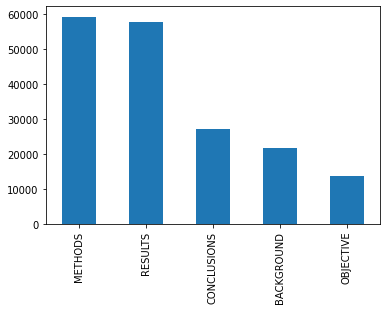

In [ ]:
#distribution of labels in train data

df_train.target.value_counts().plot(kind = 'bar')

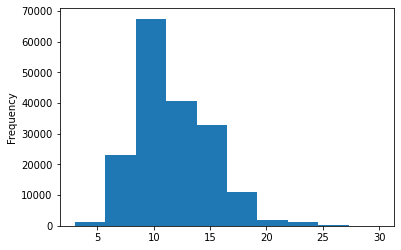

In [ ]:
df_train.total_lines.plot.hist()

## Get lists of sentences

In [ ]:
train_sentences = df_train['text'].tolist()
val_sentences = df_val['text'].tolist()
test_sentences = df_test['text'].tolist()

In [ ]:
len(train_sentences), len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
## make numeric labels
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(df_train['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(df_val['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(df_test['target'].to_numpy().reshape(-1,1))

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(df_train['target'].to_numpy())
val_labels_encoded = label_encoder.transform(df_val['target'].to_numpy())
test_labels_encoded = label_encoder.transform(df_test['target'].to_numpy())

In [ ]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([('tf-idf',TfidfVectorizer()),
                    ('clf',MultinomialNB())])

In [ ]:
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
# make prediction using our baseline_model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-19 10:31:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-19 10:31:43 (83.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback , plot_loss_curves ,calculate_results 

In [ ]:
baseline_results = calculate_results(val_labels_encoded,baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# preparing our data for deep sequence model



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len , np.max(sent_lens), np.min(sent_lens)

(26.338269273494777, 296, 1)

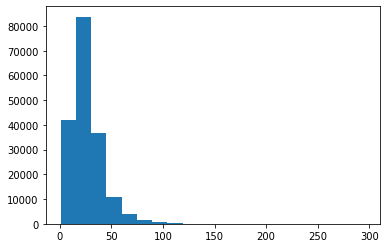

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins = 20);

In [ ]:
#How long of a sentence length covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens,q = 95))
output_seq_len

55

In [ ]:
#output_seq_len = int(np.percentile(sent_lens,q = 99))
#output_seq_len

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
#Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [ ]:
#test out text vectorizer on random sentences

import random

In [ ]:
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence)}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
 to determine ( @ ) the frequency of ih in premature infants after discontinuation of routine caffeine treatment and ( @ ) whether extending caffeine treatment to @ weeks ' postmenstrual age ( pma ) reduces ih .

Length of text: 210

Vectorized text: [[    6   228     2   400     4  4587     5  2264   337    21  1565     4
    633  2597    19     3   180  8463  2597    19     6    53  8843   103
  11463   827  4587     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab:{rct_20k_text_vocab[:5]}')
print(f'least common words in the vocab:{rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                  output_dim = 128, #number of output dim drastically changes number of paramters
                                  mask_zero = True,
                                  name = 'token_embedding'
                                  )

In [ ]:
#show example embedding
print(f'Sentence before vectorization:\n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding:\n {vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}')
print(f'Embedded sentence shape :\n {embedded_sentence.shape}')

Sentence before vectorization:
 to determine ( @ ) the frequency of ih in premature infants after discontinuation of routine caffeine treatment and ( @ ) whether extending caffeine treatment to @ weeks ' postmenstrual age ( pma ) reduces ih .
Sentence after vectorization (before embedding:
 [[    6   228     2   400     4  4587     5  2264   337    21  1565     4
    633  2597    19     3   180  8463  2597    19     6    53  8843   103
  11463   827  4587     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.01299143 -0.03716853  0.01830549 ... -0.04616643 -0.02423886
   -0.03990202]
  [ 0.02724778 -0.03075286  0.03351049 ...  0.01545521 -0.01044282
    0.04919766]
  [ 0.01565684 -0.04970238  0.01603476 ...  0.01741297 -0.01253071
    0.02864968]
  ...
  [ 0.04944264  0.04729133  0.00990795 ... -0.00046372  0.04779318
    0.01204453]
 

## Creating datasets (making sure our data loads as fast as possible)

reference : https://www.tensorflow.org/guide/data_performance

In [ ]:
#Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
train_labels_one_hot.shape , train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
#Take the TensorSliceDataset into prefetched dataset

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)#let tensorflow automatically decide the size
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1 : Conv1D with token embeddings

In [ ]:
#Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,) ,dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5 , padding = 'same' , activation = 'relu')(token_embedding)
x = layers.GlobalAveragePooling1D()(x) # condense the outpts of our feature vectors from conv layer
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs,outputs)

In [ ]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
dir_name = 'milestone_2'

In [ ]:
histroy_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = dir_name,
                                                                       experiment_name = 'Conv1D_Model')] )

Saving TensorBoard log files to: milestone_2/Conv1D_Model/20220119-103208
Epoch 1/5
562/562 [==============================] - 57s 101ms/step - loss: 0.9263 - accuracy: 0.6350 - val_loss: 0.6930 - val_accuracy: 0.7350
Epoch 2/5
562/562 [==============================] - 56s 100ms/step - loss: 0.6599 - accuracy: 0.7561 - val_loss: 0.6323 - val_accuracy: 0.7716
Epoch 3/5
562/562 [==============================] - 56s 99ms/step - loss: 0.6176 - accuracy: 0.7744 - val_loss: 0.5985 - val_accuracy: 0.7809
Epoch 4/5
562/562 [==============================] - 56s 100ms/step - loss: 0.5882 - accuracy: 0.7898 - val_loss: 0.5795 - val_accuracy: 0.7932
Epoch 5/5
562/562 [==============================] - 57s 101ms/step - loss: 0.5900 - accuracy: 0.7919 - val_loss: 0.5621 - val_accuracy: 0.7962


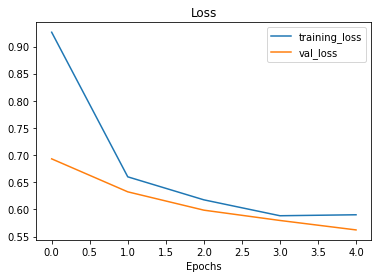

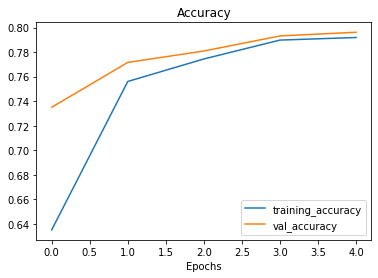

In [ ]:
plot_loss_curves(histroy_model_1)

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.5610 - accuracy: 0.8007


[0.5609814524650574, 0.8007083535194397]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)

In [ ]:
def model_results(model,y_true,validation_data):
  model_pred_probs = model.predict(validation_data)
  model_preds = tf.squeeze(np.argmax(model_pred_probs, axis = 1))
  model_results = calculate_results(y_true = y_true,
                                    y_pred = model_preds)
  return model_results

In [ ]:
model_1_results = model_results(model_1,
                                y_true = val_labels_encoded,
                                validation_data = valid_dataset)

In [ ]:
model_1_results

{'accuracy': 80.07083278167616,
 'f1': 0.7975567357201117,
 'precision': 0.8011920265147686,
 'recall': 0.8007083278167616}

## Model 2 : Feature extraction with pretrained token embedding

reference : https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
#download pretrained tensorflow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name = 'universal_sentence_encoder')

In [ ]:
#Test out of the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence: {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n {use_embedded_sentence}\n')
print(f'length after embedding:\n {len(use_embedded_sentence[0])}\n')

Random sentence: adverse events ( aes ) occurred in @ % , @ % , and @ % of patients , and serious aes occurred in @ % , @ % , and @ % of patients .
Sentence after embedding:
 [[-0.0266442   0.06650238 -0.04380094 -0.02511616  0.07902536  0.01957569
  -0.01010744 -0.03309953 -0.03826108  0.01147285  0.08343324 -0.06121542
   0.02771736  0.07007635  0.02126204  0.04586772 -0.08402286 -0.06994548
   0.02938817 -0.04232827  0.06893381  0.03419052  0.01573376 -0.0694062
  -0.05238879 -0.0057681   0.04435274 -0.00721642  0.08086164  0.02950386
   0.061139    0.08420291  0.00341542 -0.02405158 -0.04367292 -0.03066227
  -0.05905061  0.05820428 -0.03146794 -0.07224765 -0.03588278 -0.0197778
   0.05883391 -0.07038837  0.04145847  0.05809341 -0.04221194 -0.03492729
   0.06456308  0.04321193  0.03191681  0.06383202 -0.06570511  0.01354472
   0.03879602  0.02875551  0.00936825  0.05648154  0.01014688  0.03526498
  -0.05082386 -0.03116257  0.00939666  0.06143661 -0.00240152  0.02925768
  -0.00996406

## Building and fitting an NLP feature extraction model using pretrained embeddings

In [ ]:
inputs = layers.Input(shape = [], dtype = tf.string )
pretrained_embedding = tf_hub_embedding_layer(inputs) # token text and create embedding of each sequence (512 long)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
# Note : you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'model_2_USE_feature_extractor')

model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = dir_name,
                                                                       experiment_name = 'USE_feature_extractor')])

Saving TensorBoard log files to: milestone_2/USE_feature_extractor/20220119-103731
Epoch 1/5
562/562 [==============================] - 12s 15ms/step - loss: 0.9157 - accuracy: 0.6464 - val_loss: 0.7950 - val_accuracy: 0.6918
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7682 - accuracy: 0.7018 - val_loss: 0.7539 - val_accuracy: 0.7021
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7518 - accuracy: 0.7128 - val_loss: 0.7380 - val_accuracy: 0.7131
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7182 - accuracy: 0.7238 - val_loss: 0.7102 - val_accuracy: 0.7324
Epoch 5/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7253 - accuracy: 0.7210 - val_loss: 0.6911 - val_accuracy: 0.7347


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6973 - accuracy: 0.7348


[0.6973399519920349, 0.7348073720932007]

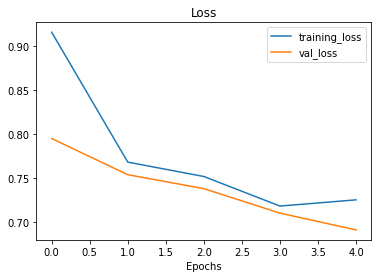

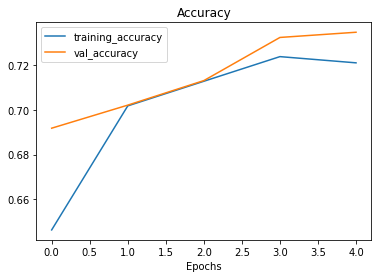

In [ ]:
plot_loss_curves(history_model_2)

In [ ]:
model_2_results = model_results(model_2,
                                y_true = val_labels_encoded,
                                validation_data = valid_dataset)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
model_2_results

{'accuracy': 73.48073613133855,
 'f1': 0.7289172357010698,
 'precision': 0.731029264372925,
 'recall': 0.7348073613133854}

In [ ]:
model_1_results

{'accuracy': 80.07083278167616,
 'f1': 0.7975567357201117,
 'precision': 0.8011920265147686,
 'recall': 0.8007083278167616}

## Model 3 : Conv1D with character embeddings

### Create a character level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
#split sequence-level data splits into character -level data_spits)
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

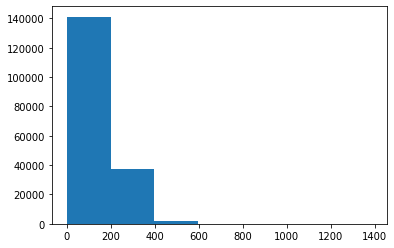

In [ ]:
plt.hist(char_lens,bins = 7);

In [ ]:
#Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet , len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
#Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token/[UNK]
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize = None,
                                    name = 'char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab:{len(char_vocab)}')
print(f'5 most common characters : {char_vocab[:5]}')
print(f'5 least common characters : {char_vocab[-5:]}')

Number of different characters in character vocab:28
5 most common characters : ['', '[UNK]', 'e', 't', 'i']
5 least common characters : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'length of random_train_chars {[random_train_chars.split()]}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized char:\n {vectorized_chars}')
print(f'\nLength of vectorized chars : {len(vectorized_chars[0])}')

Charified text:
 t h e   t o t a l   s u c c e s s   r a t e   a t   @   w e e k s   w a s   l o w e r   f o r   e x p e c t a n t   t h a n   f o r   s u r g i c a l   m a n a g e m e n t   (   @   v s   @   %   ;   p   =   @   )   .
length of random_train_chars [['t', 'h', 'e', 't', 'o', 't', 'a', 'l', 's', 'u', 'c', 'c', 'e', 's', 's', 'r', 'a', 't', 'e', 'a', 't', '@', 'w', 'e', 'e', 'k', 's', 'w', 'a', 's', 'l', 'o', 'w', 'e', 'r', 'f', 'o', 'r', 'e', 'x', 'p', 'e', 'c', 't', 'a', 'n', 't', 't', 'h', 'a', 'n', 'f', 'o', 'r', 's', 'u', 'r', 'g', 'i', 'c', 'a', 'l', 'm', 'a', 'n', 'a', 'g', 'e', 'm', 'e', 'n', 't', '(', '@', 'v', 's', '@', '%', ';', 'p', '=', '@', ')', '.']]

Vectorized char:
 [[ 3 13  2  3  7  3  5 12  9 16 11 11  2  9  9  8  5  3  2  5  3 20  2  2
  23  9 20  5  9 12  7 20  2  8 17  7  8  2 24 14  2 11  3  5  6  3  3 13
   5  6 17  7  8  9 16  8 18  4 11  5 12 15  5  6  5 18  2 15  2  6  3 21
   9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

## Creating a charcter level embedding:

In [ ]:
char_embed =layers.Embedding(input_dim = len(char_vocab), # number of different characters
                             output_dim = 24, # this is the size of the embedding in the paper (figure 1)
                             mask_zero = True,
                             name = 'char_embed')

In [ ]:
# test our character embedding layer
print(f'Charified text : \n {random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars. (after vectorization and embedding) : \n {char_embed_example}')
print(f'Embedded chars shape : \n {char_embed_example.shape}')
print(f'Length of charified text : \n {len(random_train_chars)}')

Charified text : 
 t h e   t o t a l   s u c c e s s   r a t e   a t   @   w e e k s   w a s   l o w e r   f o r   e x p e c t a n t   t h a n   f o r   s u r g i c a l   m a n a g e m e n t   (   @   v s   @   %   ;   p   =   @   )   .
Embedded chars. (after vectorization and embedding) : 
 [[[ 0.00083058  0.03352585 -0.04307758 ...  0.03429807  0.03831117
    0.0392541 ]
  [-0.0305071  -0.00184268 -0.00578108 ... -0.01821616  0.0472925
   -0.00292847]
  [ 0.04613404 -0.00882391  0.04722747 ... -0.01174877 -0.0146183
   -0.01191262]
  ...
  [ 0.0234386   0.00932823 -0.00542967 ... -0.03299256 -0.02201608
   -0.02243151]
  [ 0.0234386   0.00932823 -0.00542967 ... -0.03299256 -0.02201608
   -0.02243151]
  [ 0.0234386   0.00932823 -0.00542967 ... -0.03299256 -0.02201608
   -0.02243151]]]
Embedded chars shape : 
 (1, 290, 25)
Length of charified text : 
 217


In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string )
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors) # token text and create embedding of each sequence (512 long)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same',
                  activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
# Note : you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'model_3_conv1d_char_embedding')

model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
#create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = dir_name,
                                                                       experiment_name = 'character_embedding')])

Saving TensorBoard log files to: milestone_2/character_embedding/20220119-103934
Epoch 1/3
562/562 [==============================] - 17s 30ms/step - loss: 1.2615 - accuracy: 0.4966 - val_loss: 1.0284 - val_accuracy: 0.5888
Epoch 2/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9971 - accuracy: 0.5974 - val_loss: 0.9297 - val_accuracy: 0.6310
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9153 - accuracy: 0.6398 - val_loss: 0.8605 - val_accuracy: 0.6606


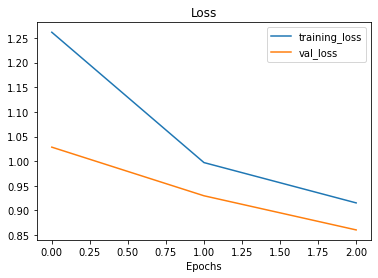

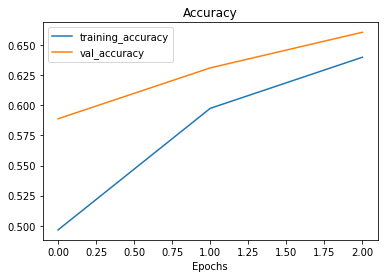

In [ ]:
plot_loss_curves(model_3_history)

In [ ]:
model_3_results = model_results(model_3,
                                y_true = val_labels_encoded,
                                validation_data = val_char_dataset)

In [ ]:
model_3_results

{'accuracy': 65.89765656030715,
 'f1': 0.6501473830885117,
 'precision': 0.6528907769708945,
 'recall': 0.6589765656030716}

## Experiment 4 : concatenating models - 

token embedding + characters embeddings (hybrid)

In [ ]:
#setup token input/model
token_inputs = layers.Input(shape = [], dtype =tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [ ]:
#setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs = char_bi_lstm)

In [ ]:
#concatenate token an char inputs
token_char_concat = layers.Concatenate(name = 'token_char_concat')([token_model.output,
                                                                    char_model.output])

In [ ]:
#create output layers - adding in dropout
combined_dropout = layers.Dropout(rate = 0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(rate = 0.5)(combined_dense)
output_layer = layers.Dense(num_classes , activation = 'softmax')(final_dropout)

In [ ]:
#Construct model with char and token inputs

model_4 = tf.keras.Model(inputs =[token_model.input,char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

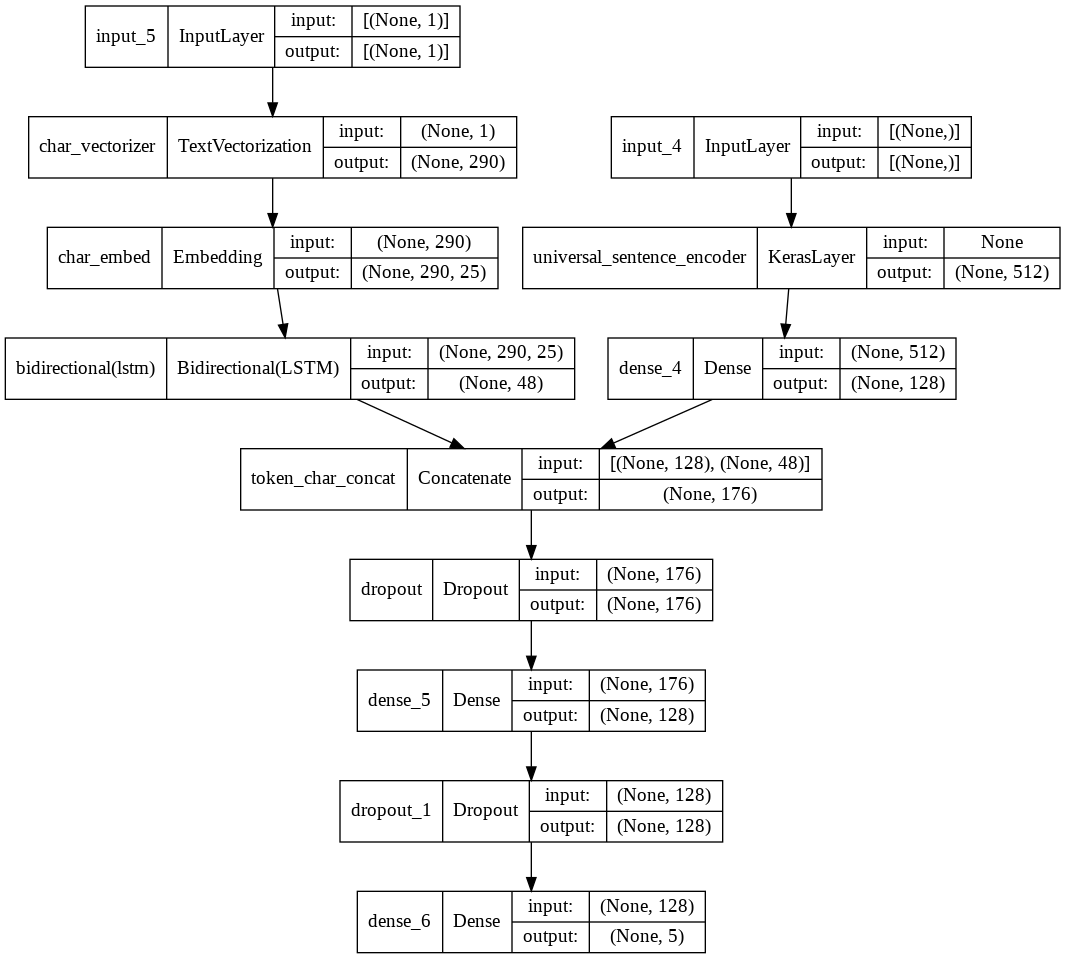

In [ ]:
#Plot hybrd token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
model_4.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
## Combining token and character data into a tf.data Dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))

In [ ]:
#Prefetch and batch train_data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
                                                                   

In [ ]:
#check out our training char and token embedding dataset - the order of the data is important, and is dependent on how your model is ordered
train_char_token_dataset , val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
model_4.fit(train_char_token_dataset,
            steps_per_epoch = int(0.1*len(train_char_token_dataset)),
            epochs = 5,
            validation_data = val_char_token_dataset,
            validation_steps = int(0.1*len(val_char_token_dataset)),
            callbacks = [create_tensorboard_callback(dir_name = dir_name,
                                                     experiment_name = 'token and char model')])

Saving TensorBoard log files to: milestone_2/token and char model/20220119-104107
Epoch 1/5
562/562 [==============================] - 197s 334ms/step - loss: 0.9827 - accuracy: 0.6123 - val_loss: 0.7875 - val_accuracy: 0.6975
Epoch 2/5
562/562 [==============================] - 177s 316ms/step - loss: 0.8025 - accuracy: 0.6876 - val_loss: 0.7180 - val_accuracy: 0.7257
Epoch 3/5
562/562 [==============================] - 173s 308ms/step - loss: 0.7695 - accuracy: 0.7056 - val_loss: 0.6901 - val_accuracy: 0.7404
Epoch 4/5
562/562 [==============================] - 164s 292ms/step - loss: 0.7371 - accuracy: 0.7179 - val_loss: 0.6683 - val_accuracy: 0.7447
Epoch 5/5
562/562 [==============================] - 168s 299ms/step - loss: 0.7463 - accuracy: 0.7155 - val_loss: 0.6524 - val_accuracy: 0.7513


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 70s 74ms/step - loss: 0.6614 - accuracy: 0.7465


[0.6613614559173584, 0.7465245723724365]

In [105]:
model_4_results = model_results(model_4,
                                y_true = val_labels_encoded,
                                validation_data = val_char_token_dataset)

In [106]:
model_4_results

{'accuracy': 74.65245597775719,
 'f1': 0.7410456150365349,
 'precision': 0.7440605090534647,
 'recall': 0.7465245597775718}

In [107]:
model_1_results

{'accuracy': 80.07083278167616,
 'f1': 0.7975567357201117,
 'precision': 0.8011920265147686,
 'recall': 0.8007083278167616}

## Create positional embeddings

In [108]:
#How many different line numbers are there
df_train['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

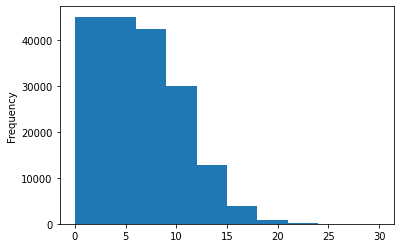

In [109]:
df_train['line_number'].plot.hist()

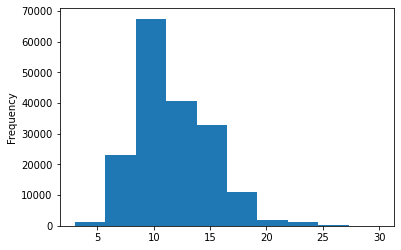

In [110]:
df_train['total_lines'].plot.hist()

In [111]:
# use TensorFlow to create one-hot-encoded tensors of our line number
train_line_numbers_one_hot =tf.one_hot(df_train['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot =tf.one_hot(df_val['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot =tf.one_hot(df_test['line_number'].to_numpy(), depth = 15)

train_total_line_numbers_one_hot =tf.one_hot(df_train['total_lines'].to_numpy(), depth = 20)
val_total_line_numbers_one_hot =tf.one_hot(df_val['total_lines'].to_numpy(), depth = 20)
test_total_line_numbers_one_hot =tf.one_hot(df_test['total_lines'].to_numpy(), depth = 20)

In [112]:
train_line_numbers_one_hot.shape , val_line_numbers_one_hot.shape

(TensorShape([180040, 15]), TensorShape([30212, 15]))

In [113]:
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [114]:
train_total_line_numbers_one_hot[:10],train_total_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [115]:
#check the coverage of a total_lines values of 20

np.percentile(df_train.total_lines,95)

18.0

### building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_line' feature
5. Combine the outputs of 1&2,
6. Combine of t 3 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribird embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs into tf.keras.Model

In [116]:
#1.
token_inputs = layers.Input(shape = [], dtype = tf.string , name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs,
                             name = 'token_model')

#2.
char_inputs = layers.Input(shape = (1,) , dtype = 'string' , name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_outputs,
                            name ='char_model')

#3.
line_number_inputs = layers.Input(shape = (15,) , dtype = tf.int32, name = 'line_number_input')
x = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                    outputs = x)

#4.

total_lines_inputs = layers.Input(shape = (20,), dtype = tf.int32, name = 'total_line_inputs')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

#5. Combine token and char embedding into a hybrid embedding

combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output,
                                                                                char_model.output])


z = layers.Dense(256,activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6 . COmbine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = 'char_token_position_embedding')([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
#7. Create output layer
output_layer = layers.Dense(5,activation = 'softmax' , name = 'output_layer')(tribrid_embeddings)

#8. Combine model

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input
                                   ],
                         outputs = output_layer,
                         name = 'tribrid_embedding_model')

In [117]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

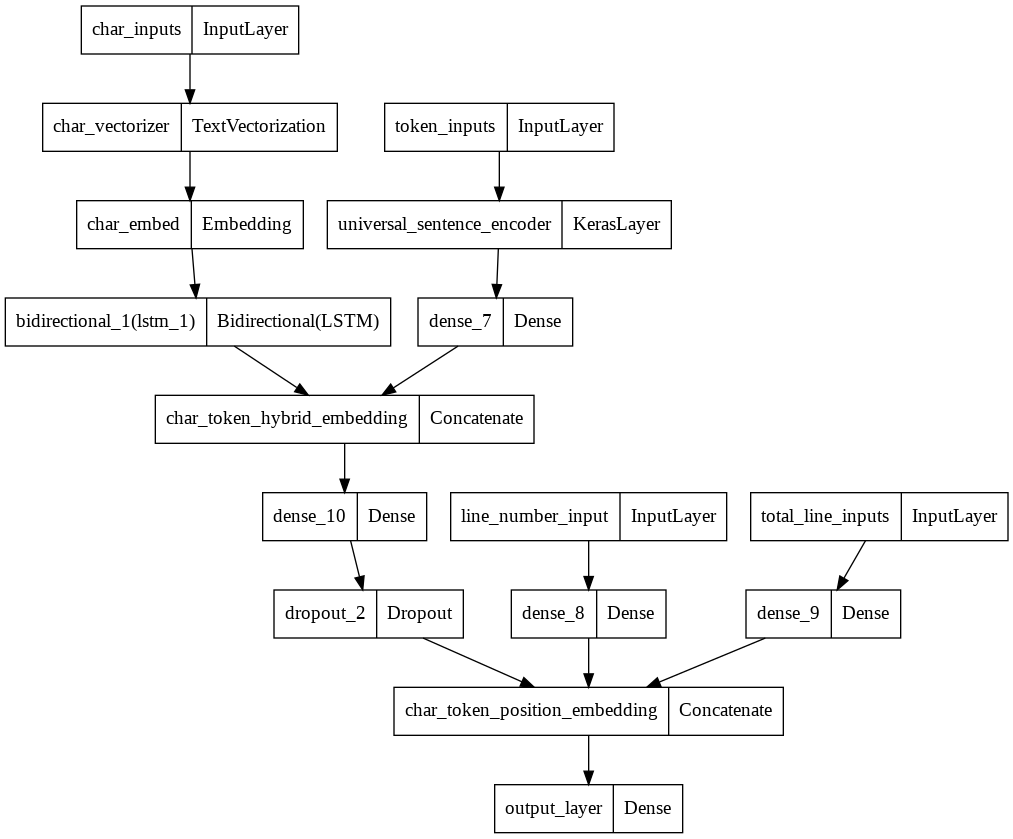

In [118]:
plot_model(model_5)

What is label smoothing?

If our model gets too confident on a single class, it may get stuck on that class and not consider other classes.

E.g. [0,0,1,0,0]

what label smoothing does is it assigns some of the value from the highest pred prob to other classes in turn, hopefully, improving generalization [0.01,0.01,0.96,0.01,0.01]

reference : https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [119]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [120]:
#Creating training and validation datasets

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_line_numbers_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                    train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_line_numbers_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                  val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_line_numbers_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,
                                                    test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
train_char_token_pos_dataset, test_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [124]:
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs = 5,
                              validation_data = test_char_token_pos_dataset,
                              validation_steps = int(0.1*len(test_char_token_pos_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = dir_name,
                                                                       experiment_name = 'token and char pos model')])

Saving TensorBoard log files to: milestone_2/token and char pos model/20220119-110122
Epoch 1/5
562/562 [==============================] - 191s 324ms/step - loss: 1.0948 - accuracy: 0.7252 - val_loss: 1.0003 - val_accuracy: 0.7909
Epoch 2/5
562/562 [==============================] - 162s 289ms/step - loss: 0.9675 - accuracy: 0.8146 - val_loss: 0.9638 - val_accuracy: 0.8185
Epoch 3/5
562/562 [==============================] - 162s 288ms/step - loss: 0.9496 - accuracy: 0.8234 - val_loss: 0.9467 - val_accuracy: 0.8288
Epoch 4/5
562/562 [==============================] - 168s 299ms/step - loss: 0.9391 - accuracy: 0.8331 - val_loss: 0.9357 - val_accuracy: 0.8311
Epoch 5/5
562/562 [==============================] - 162s 288ms/step - loss: 0.9350 - accuracy: 0.8367 - val_loss: 0.9310 - val_accuracy: 0.8331


In [126]:
model_5_results = model_results(model_5,
                                y_true = val_labels_encoded,
                                validation_data = val_char_token_pos_dataset)

In [127]:
model_5_results

{'accuracy': 84.40685820203893,
 'f1': 0.8402072766116138,
 'precision': 0.8465583242765172,
 'recall': 0.8440685820203893}